In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.framework import arg_scope
import h5py
import math

%matplotlib inline

### Utility functions ###

In [0]:
def load_dataset_cat_vs_non_cat():
    
    # h5py.File() returns a File object. 
    train_dataset = h5py.File('drive/DeepLearning/Datasets/Coursera_Cat_Vs_NonCat/coursera_catvnoncat_train.h5', mode = 'r')
    test_dataset = h5py.File('drive/DeepLearning/Datasets/Coursera_Cat_Vs_NonCat/coursera_catvnoncat_test.h5', mode = 'r')
    #print(type(train_dataset)) # Prints <class 'h5py._hl.files.File'>
    
    #Check the contents of the File object. h5py File acts like a dictionary. So, we can list the keys it contains
    #print(list(train_dataset.keys()))
    #print(list(test_dataset.keys()))
    
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    #Since both train and test classes contain the same two classes just returning back one of them
    classes = np.array(test_dataset['list_classes'][:])
    
    train_set_y_orig = train_set_y_orig.reshape(train_set_y_orig.shape[0], 1)
    test_set_y_orig = test_set_y_orig.reshape(test_set_y_orig.shape[0], 1)
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
def create_random_mini_batches(X, Y, mini_batch_size = 32):
    
    n_samples = X.shape[0]                  
    mini_batches = []
    
    p = list(np.random.permutation(int(n_samples)))
    X_shuffled = X[p, :]
    Y_shuffled = Y[p, :]
    
    n_mini_batches = math.floor(n_samples / mini_batch_size)
    for i in range(n_mini_batches):
        
        start_pos = i * mini_batch_size
        end_pos = start_pos + mini_batch_size
        
        X_mini_batch = X_shuffled[start_pos : end_pos, :]
        Y_mini_batch = Y_shuffled[start_pos : end_pos, :]
         
        mini_batch = (X_mini_batch, Y_mini_batch)
        mini_batches.append(mini_batch)
    
    if n_samples % mini_batch_size != 0:
        
        start_pos = n_mini_batches * mini_batch_size
        
        X_mini_batch = X_shuffled[start_pos : n_samples, :]
        Y_mini_batch = Y_shuffled[start_pos : n_samples, :]
        
        mini_batch = (X_mini_batch, Y_mini_batch)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Load the dataset

In [4]:
X_train_orig, Y_train, X_test_orig, Y_test, classes = load_dataset_cat_vs_non_cat()

print('Train X shape', X_train_orig.shape)
print('Train Y shape', Y_train.shape)
print('Test X shape', X_test_orig.shape)
print('Test Y shape', Y_test.shape)
print('Classes shape', classes.shape)

Train X shape (209, 64, 64, 3)
Train Y shape (209, 1)
Test X shape (50, 64, 64, 3)
Test Y shape (50, 1)
Classes shape (2,)


### Check out some of the data and it's label

Text(0.5,1,'label = 1')

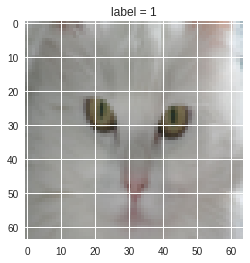

In [5]:
index = 50

plt.imshow(X_train_orig[index])
plt.title('label = ' + str(np.squeeze(Y_train[index])))

### Pre-process the data

**Normalize** - Normalize the data by dividing the matrix by 255. This should scale all the pixel values between 0 and 1.

**Reshape the data** - Reshape the image data from shape (n_samples, n_px, n_px, 3), where 3 stands for RGB channels to the shape (n_samples, n_px \* n_px \* 3). We are rolling up the image into a feature vector of size n_px \* n_px \* 3.

X shape after reshaping would be (n_samples, n_px \* n_px \* 3)

In [6]:
#Normalize the data set
X_train = X_train_orig / 255
X_test = X_test_orig / 255

#Reshape the data set
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print('X train shape after reshaping =', X_train.shape)
print('X test shape after reshaping = ', X_test.shape)

X train shape after reshaping = (209, 12288)
X test shape after reshaping =  (50, 12288)


### Build the DNN using plain TensorFlow

**Step 1 - Code the individual ops in the computation graph**
- Create Placeholders for X, Y
- Create the nn_model - all the layers and initialize them
- Compute the cost
- Create the optimizer to minimize the cost
- Evaluate the model

**Step 2 - Build the computation graph**
- Combine all the steps in Step 1 to build the computation graph
- Initialize the variables
- Create a Saver object to save the learnt parameters after the model is trained

**Step 3 - Execute the graph**
- Create mini batches so that gradient descent works on these mini batches for every step instead of all instances
- Train the model for a given number of epochs
- Print the cost, train accuracy & test accuracy at regular interval of epochs
- Plot the training error (cost) vs epochs
- Save the parameters

**Step 4 - Predict for any data**
- Build a method to pass random data for the model to predict based on the parameters learnt through training

### Create the placeholders

In [0]:
def create_placeholders(n_inputs):
    '''
    n_inputs - A scalar containing the number of input features
    '''
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = 'Y')
    
    return X, Y

### Create the NN model

In [0]:
def nn_model(X, n_neurons):
    '''
    X - input Tensor X
    n_neurons - A scalar containing the number of neurons in each layer including both hidden layers and output layer 
    '''
    with arg_scope([fully_connected], weights_regularizer = l2_regularizer(scale = 0.01)):
        hidden_layer_1 = fully_connected(X, n_neurons['hidden_layer_1'], scope = 'hidden_layer_1')
        hidden_layer_2 = fully_connected(hidden_layer_1, n_neurons['hidden_layer_2'], scope = 'hidden_layer_2')
        hidden_layer_3 = fully_connected(hidden_layer_2, n_neurons['hidden_layer_3'], scope = 'hidden_layer_3')
        logits = fully_connected(hidden_layer_3, n_neurons['output_layer'], activation_fn = None, scope = 'output_layer')
    
    return logits

### Compute the cost

In [0]:
def compute_cost(labels, logits):
    '''
    labels - label tensor Y
    logits - Tensor containing the values of the output layer before passing to the activation function
    '''
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    base_cost = tf.reduce_mean(cross_entropy)
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    cost = tf.add_n([base_cost] + reg_losses, name = 'cost')
    
    return cost

### Create the optimizer and the training operation

In [0]:
def optimizer(learning_rate, cost):
    '''
    learning_rate - A scalar value containing the learning rate for the backpropagation step
    cost - Overall cost from the forward propagation step for one set of mini batch instance
    '''
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost)
    
    return training_op

### Evaluate the model

We will use accuracy as the evaluation metric

In [0]:
def evaluate_model(logits, Y):
    '''
    logits - An array containing the values from the output layer
    Y - An array containing the labels
    '''
    
    #Compute the probability using the sigmoid function
    y_pred = tf.nn.sigmoid(logits)
    #Convert it to 0 or 1 class based on the probability and cast it to integer
    y_pred = tf.cast(y_pred > 0.5, tf.int64)
    
    #Create a boolean tensor by comparing the model prediction against the labels
    correct_prediction = tf.equal(y_pred, tf.cast(Y, tf.int64))
    #Compute the accuracy across all the instances
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

### Build the computation graph & execute it

In [0]:
def train_model(X_train, Y_train, X_test, Y_test, n_neurons, 
               learning_rate = 0.01, mini_batch_size = 64, n_epochs = 50, print_cost = False):
    
    tf.reset_default_graph()
    
    #Declare and initialize the required variables
    (n_samples, n_inputs) = X_train.shape
    costs = []
    
    #Create Placeholder
    X, Y = create_placeholders(n_inputs)
    
    #Create the nn_model
    logits = nn_model(X, n_neurons) 
    
    #Compute the cost
    cost = compute_cost(Y, logits)
    
    #Optimize the cost using Gradient Descent Optimizer
    training_op = optimizer(learning_rate, cost)
    
    #Evaluate the model
    accuracy = evaluate_model(logits, Y)
    
    #Initialize the variables
    init = tf.global_variables_initializer()
    
    #Create the Saver object
    saver = tf.train.Saver()
    
    #Execute the Graph - Train the model
    with tf.Session() as sess:
        init.run()
        
        n_mini_batches = int(n_samples / mini_batch_size)
        
        for epoch in range(1, n_epochs + 1):
            epoch_cost = 0
            mini_batches = create_random_mini_batches(X_train, Y_train, mini_batch_size)
            
            for mini_batch in mini_batches:
                (X_mini_batch, Y_mini_batch) = mini_batch
                _, mini_batch_cost = sess.run([training_op, cost], feed_dict = {X: X_mini_batch, Y: Y_mini_batch})
                
                epoch_cost += mini_batch_cost
            
            epoch_cost = epoch_cost / n_mini_batches
            train_accuracy = accuracy.eval(feed_dict = {X: X_train, Y: Y_train})
            test_accuracy = accuracy.eval(feed_dict = {X: X_test, Y: Y_test})
            
            if print_cost and epoch % 100 == 0:
                print('At epoch', epoch, 'Cost =', epoch_cost, '| Train Accuracy =', train_accuracy, 
                      '| Test Accuracy =', test_accuracy)
            
            if epoch % 10 == 0:
                costs.append(epoch_cost)
            
        saver_path = saver.save(sess, './my_model_final.ckpt')
        
    print('Final - Train Accuracy =', train_accuracy, '| Test Accuracy =', test_accuracy)
        
    plt.plot(costs)
    plt.xlabel('# of Epochs (in tens)')
    plt.ylabel('Training Error - Cost')
    plt.title('Training Error Vs Epochs')
    plt.show()
    
    return saver_path

At epoch 100 Cost = 0.7360601524511973 | Train Accuracy = 1.0 | Test Accuracy = 0.72
At epoch 200 Cost = 0.43206074337164563 | Train Accuracy = 1.0 | Test Accuracy = 0.74
At epoch 300 Cost = 0.2744187464316686 | Train Accuracy = 1.0 | Test Accuracy = 0.76
At epoch 400 Cost = 0.22603609164555868 | Train Accuracy = 1.0 | Test Accuracy = 0.72
At epoch 500 Cost = 0.18692433585723242 | Train Accuracy = 1.0 | Test Accuracy = 0.76
At epoch 600 Cost = 0.15907503912846246 | Train Accuracy = 1.0 | Test Accuracy = 0.74
At epoch 700 Cost = 0.1371767856180668 | Train Accuracy = 1.0 | Test Accuracy = 0.76
At epoch 800 Cost = 0.11896992474794388 | Train Accuracy = 1.0 | Test Accuracy = 0.74
At epoch 900 Cost = 0.12237856909632683 | Train Accuracy = 1.0 | Test Accuracy = 0.74
At epoch 1000 Cost = 0.11347636828819911 | Train Accuracy = 1.0 | Test Accuracy = 0.76
Final - Train Accuracy = 1.0 | Test Accuracy = 0.76


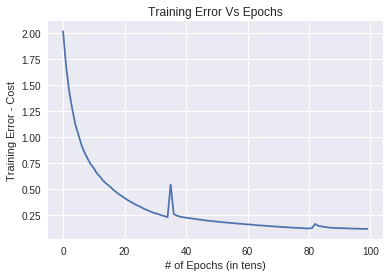

'./my_model_final.ckpt'

In [13]:
n_neurons = {'hidden_layer_1': 100,
            'hidden_layer_2': 50,
            'hidden_layer_3': 10, 
            'output_layer': 1}
train_model(X_train, Y_train, X_test, Y_test, n_neurons, learning_rate = 0.0001, n_epochs = 1000, mini_batch_size = 32,
            print_cost = True)